420-A52-SF - Algorithmes d'apprentissage supervisé - Hiver 2020 - Spécialisation technique en Intelligence Artificielle<br/>
MIT License - Copyright (c) 2020 Mikaël Swawola
<br/>
![Projet #2 - Solution](static/project2-banner.png)
<br/>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 0 - Import des bibliothèques

In [2]:
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, f1_score, roc_curve, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.utils.fixes import loguniform
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

from helpers import convertDir2Deg, plot_confusion_matrix

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de la visualisation
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, })
sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1 - Chargement et exploration sommaire des données

In [4]:
AUS = pd.read_csv('AUS_train.csv', index_col=['Date'], parse_dates=True)

In [5]:
AUS.head()

,Unnamed: 0,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-01,0,Albury,13.4,22.9,0.6,4.8,8.5,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,No
2008-12-03,2,Albury,12.9,25.7,0.0,4.8,8.5,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No,No
2008-12-04,3,Albury,9.2,28.0,0.0,4.8,8.5,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No,No
2008-12-06,5,Albury,14.6,29.7,0.2,4.8,8.5,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,5.0,5.0,20.6,28.9,No,No
2008-12-07,6,Albury,14.3,25.0,0.0,4.8,8.5,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,5.0,18.1,24.6,No,No


In [6]:
AUS = AUS.drop(columns=['Unnamed: 0'])

In [7]:
AUS.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

## Date

In [8]:
AUS['Year'] = AUS.index.year
AUS['Month'] = AUS.index.month

### Location

In [9]:
AUS['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

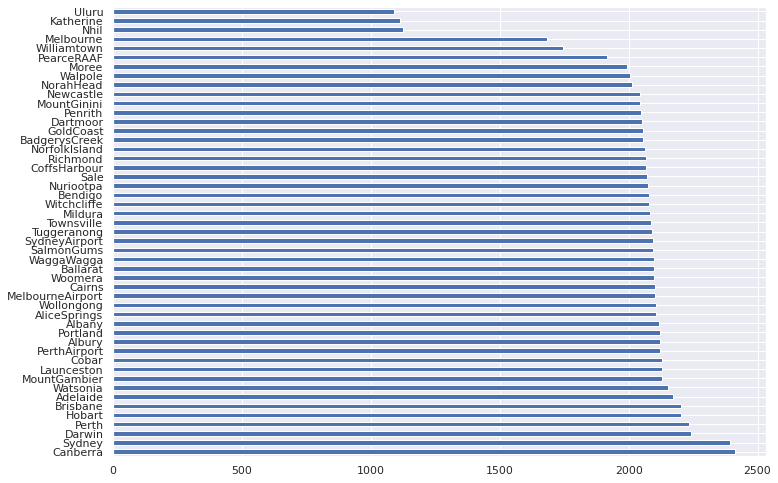

In [10]:
AUS['Location'].value_counts().plot(kind='barh')

In [11]:
AUS = pd.get_dummies(AUS, columns = ['Location'], prefix="loc", drop_first=True)

In [12]:
AUS.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Year', 'Month', 'loc_Albany',
       'loc_Albury', 'loc_AliceSprings', 'loc_BadgerysCreek', 'loc_Ballarat',
       'loc_Bendigo', 'loc_Brisbane', 'loc_Cairns', 'loc_Canberra',
       'loc_Cobar', 'loc_CoffsHarbour', 'loc_Dartmoor', 'loc_Darwin',
       'loc_GoldCoast', 'loc_Hobart', 'loc_Katherine', 'loc_Launceston',
       'loc_Melbourne', 'loc_MelbourneAirport', 'loc_Mildura', 'loc_Moree',
       'loc_MountGambier', 'loc_MountGinini', 'loc_Newcastle', 'loc_Nhil',
       'loc_NorahHead', 'loc_NorfolkIsland', 'loc_Nuriootpa', 'loc_PearceRAAF',
       'loc_Penrith', 'loc_Perth', 'loc_PerthAirport', 'loc_Portland',
       'loc_Richmond', 'loc_Sale', 'loc_SalmonGums', 'l

## Wind direction

In [13]:
AUS['WindGustDir'] = AUS['WindGustDir'].apply(lambda d : convertDir2Deg(d))
AUS['WindDir9am'] = AUS['WindDir9am'].apply(lambda d : convertDir2Deg(d))
AUS['WindDir3pm'] = AUS['WindDir3pm'].apply(lambda d : convertDir2Deg(d))

In [14]:
AUS['Wind1Cos'] = np.cos(AUS['WindGustDir']*2*np.pi/360)
AUS['Wind1Sin'] = np.sin(AUS['WindGustDir']*2*np.pi/360)
AUS['Wind2Cos'] = np.cos(AUS['WindDir9am']*2*np.pi/360)
AUS['Wind2Sin'] = np.sin(AUS['WindDir9am']*2*np.pi/360)
AUS['Wind3Cos'] = np.cos(AUS['WindDir3pm']*2*np.pi/360)
AUS['Wind3Sin'] = np.sin(AUS['WindDir3pm']*2*np.pi/360)

In [15]:
AUS = AUS.drop(columns=['WindGustDir','WindDir9am','WindDir3pm'])

#### Vérification de la proportion des classes positives (Rain) et négatives (No rain) 

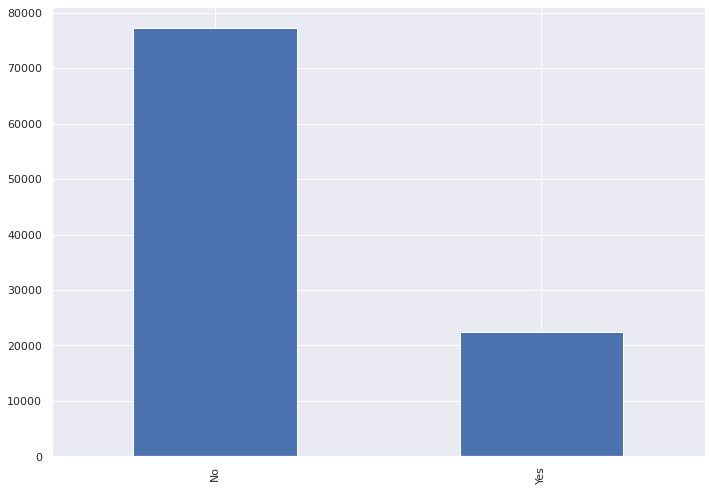

In [16]:
AUS['RainTomorrow'].value_counts().plot(kind='bar')

In [17]:
AUS['RainTomorrow'] = (AUS['RainTomorrow'] == 'Yes').astype(int)
AUS['RainToday'] = (AUS['RainToday'] == 'Yes').astype(int)

In [18]:
y = AUS[['RainTomorrow']].values.ravel() # Le ravel sert à éviter un warning tanant ...

AUS = AUS.drop(columns=['RainTomorrow'])
X = AUS.values

m = len(y)

## 3 - Sous-échantillonnage du jeu de données

Puisque le jeu de données est volumineux, nous allons commencer cette étude d'apprentissage supervisé avec seulement 20 % des données

In [19]:
X_sub, y_sub = resample(X, y, n_samples=0.2*m, stratify=y, random_state=2020)

## 4 - Modèle de référence

In [20]:
clf_dummy = DummyClassifier(strategy="most_frequent").fit(X_sub, y_sub)
dummy_score = log_loss(y_sub, clf_dummy.predict_proba(X_sub)[:,1])

In [21]:
history = {}
history['Baseline'] = dummy_score
history

{'Baseline': 7.7589495171568075}

## 5 - Régression logistique

[class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [22]:
# Standardisation
scaler = StandardScaler().fit(X_sub)
X_sub_scale = scaler.transform(X_sub)

In [23]:
# Grille de recherche
parameters = {'C':[0.01, 0.1, 1],
              'l1_ratio':[0, 0.1, 0.2, 0.3, 0.4],
              'penalty': ['none', 'elasticnet']}

# Modèle
clf_logreg = LogisticRegression(max_iter=10000,
                                  solver='saga',
                                  random_state=2020)

# Recherche sur grille avec validation croisée
clf_logreg_grid = GridSearchCV(clf_logreg, parameters, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1)

In [24]:
clf_logreg_grid.fit(X_sub_scale, y_sub)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   28.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=2020, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4],
                         'penalty': ['none', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

In [25]:
print(f'Meilleurs paramètres: {clf_logreg_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_logreg_grid.best_score_}')

Meilleurs paramètres: {'C': 0.1, 'l1_ratio': 0.2, 'penalty': 'elasticnet'}
Meilleur score (mean CV): -0.3604876603983897


In [26]:
history['Logistic regression'] = -clf_logreg_grid.best_score_
history

{'Baseline': 7.7589495171568075, 'Logistic regression': 0.3604876603983897}

## 6 - K plus proches voisins

[class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [27]:
# Grille de recherche
parameters = {'n_neighbors':[75, 100, 125, 150],
              'p':[1, 2],
              'weights':['uniform', 'distance']}

# Modèle
clf_knn = KNeighborsClassifier()

# Recherche sur grille avec validation croisée
clf_knn_grid = GridSearchCV(clf_knn, parameters, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1)

In [28]:
clf_knn_grid.fit(X_sub, y_sub)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [75, 100, 125, 150], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

In [29]:
print(f'Meilleurs paramètres: {clf_knn_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_knn_grid.best_score_}')

Meilleurs paramètres: {'n_neighbors': 150, 'p': 1, 'weights': 'distance'}
Meilleur score (mean CV): -0.32224499430471


In [30]:
history['KNN'] = -clf_knn_grid.best_score_
history

{'Baseline': 7.7589495171568075,
 'Logistic regression': 0.3604876603983897,
 'KNN': 0.32224499430471}

## 7 - Arbres de décision

[class sklearn.tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [31]:
# Distributions des hyperparamètres
distributions = dict(
    criterion=['gini', 'entropy'],
    ccp_alpha=loguniform(1e-4, 1e3),
    max_depth=randint(2, 128))

# Modèle
clf_tree = DecisionTreeClassifier(random_state=2020)

    
# Recherche aléatoire avec validation croisée
clf_tree_rnd = RandomizedSearchCV(clf_tree, distributions, n_iter=1000, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1, random_state=2020)

In [32]:
clf_tree_rnd.fit(X_sub, y_sub)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  4.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=2020,
          

In [33]:
print(f'Meilleurs paramètres: {clf_tree_rnd.best_params_}')
print(f'Meilleur score (mean CV): {clf_tree_rnd.best_score_}')

Meilleurs paramètres: {'ccp_alpha': 0.001012142152271772, 'criterion': 'entropy', 'max_depth': 6}
Meilleur score (mean CV): -0.39106069011934386


In [34]:
history['Decision Tree'] = -clf_tree_rnd.best_score_
history

{'Baseline': 7.7589495171568075,
 'Logistic regression': 0.3604876603983897,
 'KNN': 0.32224499430471,
 'Decision Tree': 0.39106069011934386}

## 8 - Bagging (arbres de décision)

[class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [35]:
clf_bag = BaggingClassifier(base_estimator=clf_tree_rnd.best_estimator_, n_estimators=1000, verbose=1, n_jobs=-1, random_state=2020)

In [36]:
clf_bag.fit(X_sub, y_sub)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   25.2s remaining:  1.3min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   25.6s finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.001012142152271772,
                                                        class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=6,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        ra

In [37]:
# Score de validation croisée
cv_score = cross_val_score(clf_bag, X_sub, y_sub, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


In [38]:
print(f'Score (mean CV): {cv_score}')

Score (mean CV): -0.3671654438449209


In [39]:
history['Bagging'] = -cv_score
history

{'Baseline': 7.7589495171568075,
 'Logistic regression': 0.3604876603983897,
 'KNN': 0.32224499430471,
 'Decision Tree': 0.39106069011934386,
 'Bagging': 0.3671654438449209}

## 9 - Forêts aléatoires

[class sklearn.ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [40]:
# Grille de recherche
parameters = {'ccp_alpha': [1e-3, 1e-2, 1e-1, 1],
              'criterion':['gini','entropy'],
              'max_features': [None, 'log2', 'sqrt']}

# Modèle
clf_rf = RandomForestClassifier(n_estimators=100, random_state=2020)

# Recherche sur grille avec validation croisée
clf_rf_grid = GridSearchCV(clf_rf, parameters, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1)

In [41]:
clf_rf_grid.fit(X_sub, y_sub)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [42]:
print(f'Meilleurs paramètres: {clf_rf_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_rf_grid.best_score_}')

Meilleurs paramètres: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_features': None}
Meilleur score (mean CV): -0.35768899900641327


In [43]:
history['Random Forests'] = -clf_rf_grid.best_score_
history

{'Baseline': 7.7589495171568075,
 'Logistic regression': 0.3604876603983897,
 'KNN': 0.32224499430471,
 'Decision Tree': 0.39106069011934386,
 'Bagging': 0.3671654438449209,
 'Random Forests': 0.35768899900641327}

## 10 - Gradient Boosting

In [44]:
# Grille de recherche
parameters = {
    'learning_rate': [0.01, 0.1, 1],
    'max_features': ['sqrt', None],
    'loss': ['deviance', 'exponential'],
    'ccp_alpha': [1e-5, 1e-4, 1e-3]}

# Modèle
clf_gb = GradientBoostingClassifier(n_estimators=100, random_state=2020)

# Recherche sur grille avec validation croisée
clf_gb_grid = GridSearchCV(clf_gb, parameters, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1)

In [45]:
clf_gb_grid.fit(X_sub, y_sub)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [46]:
print(f'Meilleurs paramètres: {clf_gb_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_gb_grid.best_score_}')

Meilleurs paramètres: {'ccp_alpha': 0.0001, 'learning_rate': 0.1, 'loss': 'exponential', 'max_features': None}
Meilleur score (mean CV): -0.3520269128924259


In [47]:
history['Gradient Boosting'] = -clf_gb_grid.best_score_
history

{'Baseline': 7.7589495171568075,
 'Logistic regression': 0.3604876603983897,
 'KNN': 0.32224499430471,
 'Decision Tree': 0.39106069011934386,
 'Bagging': 0.3671654438449209,
 'Random Forests': 0.35768899900641327,
 'Gradient Boosting': 0.3520269128924259}

## 11 - XGBoost

In [48]:
# Grille de recherche
parameters = {
    'learning_rate': [0.001, 0.01, 0.1],
    'reg_alpha': [1e-4, 1e-3, 1e-2],
    'reg_lambda': [1e-4, 1e-3, 1e-2]}

# Modèle
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            colsample_bytree=0.3,
                            max_depth=30,
                            n_estimators=100,
                            random_state=2020)


# Recherche sur grille avec validation croisée
clf_xgb_grid = GridSearchCV(clf_xgb, parameters, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1)

In [49]:
clf_xgb_grid.fit(X_sub, y_sub)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  4.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=30, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimato...
                                     random_state=2020, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,

In [50]:
print(f'Meilleurs paramètres: {clf_xgb_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_xgb_grid.best_score_}')

Meilleurs paramètres: {'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}
Meilleur score (mean CV): -0.350077011659007


In [51]:
history['XGBoost'] = -clf_xgb_grid.best_score_
history

{'Baseline': 7.7589495171568075,
 'Logistic regression': 0.3604876603983897,
 'KNN': 0.32224499430471,
 'Decision Tree': 0.39106069011934386,
 'Bagging': 0.3671654438449209,
 'Random Forests': 0.35768899900641327,
 'Gradient Boosting': 0.3520269128924259,
 'XGBoost': 0.350077011659007}

## 12 - Courbes d'apprentissage pour le meilleur modèle

### XGBoost

In [54]:
lcurves = defaultdict(list)

for p in tqdm([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]):
    X_, y_ = resample(X, y, n_samples=p*m, stratify=y, random_state=2020)
    Xt, Xv, yt, yv = train_test_split(X_, y_, test_size=0.3, stratify=y_, random_state=2020)
    
    clf_xgb_grid.best_estimator_.fit(Xt, yt)
    
    lcurves['Train'].append(log_loss(yt, clf_xgb_grid.predict_proba(Xt)[:,1]))
    lcurves['Val'].append(log_loss(yv, clf_xgb_grid.predict_proba(Xv)[:,1]))

100%|██████████| 11/11 [00:56<00:00,  5.12s/it]


#### Affichage des courbes d'apprentissage

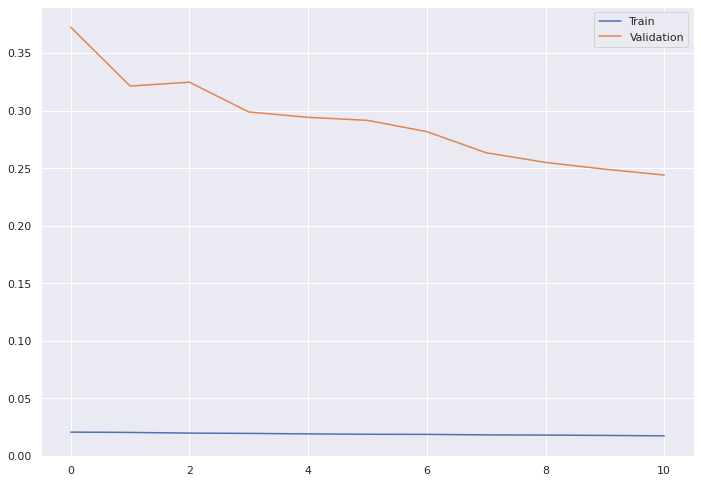

In [55]:
plt.plot(lcurves['Train'], label="Train")
plt.plot(lcurves['Val'], label="Validation")
plt.legend()

### Gradient Boosting

In [56]:
lcurves = defaultdict(list)

for p in tqdm([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]):
    X_, y_ = resample(X, y, n_samples=p*m, stratify=y, random_state=2020)
    Xt, Xv, yt, yv = train_test_split(X_, y_, test_size=0.3, stratify=y_, random_state=2020)
    
    clf_gb_grid.best_estimator_.fit(Xt, yt)
    
    lcurves['Train'].append(log_loss(yt, clf_gb_grid.predict_proba(Xt)[:,1]))
    lcurves['Val'].append(log_loss(yv, clf_gb_grid.predict_proba(Xv)[:,1]))

100%|██████████| 11/11 [02:23<00:00, 13.03s/it]


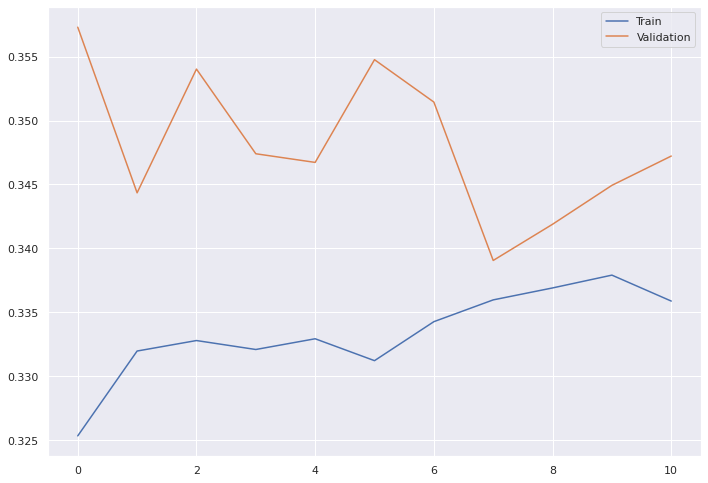

In [57]:
plt.plot(lcurves['Train'], label="Train")
plt.plot(lcurves['Val'], label="Validation")
plt.legend()

## 13 -  Réentraînement du meilleur modèle en prenant en compte les meilleurs hyperparamètres

In [58]:
clf_best = GradientBoostingClassifier(
    n_estimators=100,
    ccp_alpha=0.0001,
    learning_rate=0.1,
    loss='exponential',
    max_features= None,
    random_state=2020)

clf_best.fit(X, y)

cv_score = cross_val_score(clf_best, X, y, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1)
cv_score.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   51.5s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


-0.4349494566120762

## 14 - Métriques

#### Prédictions

In [59]:
y_train_pred_proba_best = clf_best.predict_proba(X)[:,1]

#### Aire sous la courbe

In [60]:
print(f'AUC = {roc_auc_score(y, y_train_pred_proba_best)}')

AUC = 0.8793425672328384


#### Courbe ROC

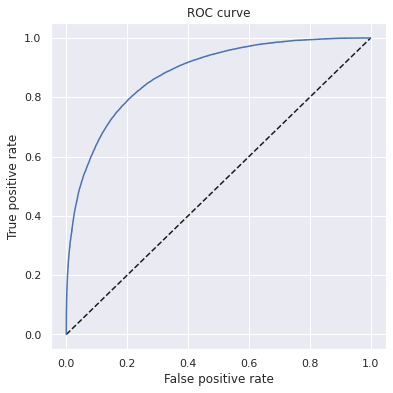

In [61]:
fpr_rf, tpr_rf, thresholds = roc_curve(y, y_train_pred_proba_best)

fig = plt.figure(4, figsize=(6, 6))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Meilleur modèle')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#### Recherche du meilleur seuil

In [62]:
selected_threshold = thresholds[np.argmax(-fpr_rf + tpr_rf)]
selected_threshold

0.20647436271489694

#### F1 score

In [63]:
f1_score(y, y_train_pred_proba_best > selected_threshold)

0.6345604002859185

#### Matrice de confusion

Confusion matrix, without normalization


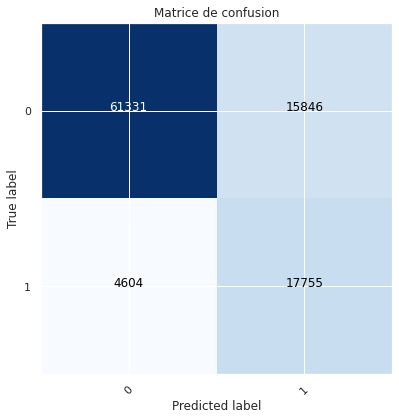

In [64]:
fig = plt.figure(3, figsize=(6, 6))

cnf_matrix = confusion_matrix(y, y_train_pred_proba_best > selected_threshold)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0','1'], title='Matrice de confusion')

In [65]:
# Accuracy
(61331+17755)/(61331+17755+15846+4604)

0.7945466966725607

## 15 - Prédictions sur le jeu de test

#### On applique les mêmes transformations que pour le jeu d'entraînement

In [67]:
AUS_test = pd.read_csv('AUS_test.csv', index_col=['Date'], parse_dates=True)
AUS_test = AUS_test.drop(columns=['Unnamed: 0'])
AUS_test['Year'] = AUS_test.index.year
AUS_test['Month'] = AUS_test.index.month
AUS_test = pd.get_dummies(AUS_test, columns = ['Location'], prefix="loc", drop_first=True)
AUS_test['WindGustDir'] = AUS_test['WindGustDir'].apply(lambda d : convertDir2Deg(d))
AUS_test['WindDir9am'] = AUS_test['WindDir9am'].apply(lambda d : convertDir2Deg(d))
AUS_test['WindDir3pm'] = AUS_test['WindDir3pm'].apply(lambda d : convertDir2Deg(d))
AUS_test['Wind1Cos'] = np.cos(AUS_test['WindGustDir']*2*np.pi/360)
AUS_test['Wind1Sin'] = np.sin(AUS_test['WindGustDir']*2*np.pi/360)
AUS_test['Wind2Cos'] = np.cos(AUS_test['WindDir9am']*2*np.pi/360)
AUS_test['Wind2Sin'] = np.sin(AUS_test['WindDir9am']*2*np.pi/360)
AUS_test['Wind3Cos'] = np.cos(AUS_test['WindDir3pm']*2*np.pi/360)
AUS_test['Wind3Sin'] = np.sin(AUS_test['WindDir3pm']*2*np.pi/360)
AUS_test = AUS_test.drop(columns=['WindGustDir','WindDir9am','WindDir3pm'])
AUS_test['RainToday'] = (AUS_test['RainToday'] == 'Yes').astype(int)
X_test = AUS_test.values

#### Calcul des prédictions sur le jeu de test

In [68]:
y_test_pred_proba_best = clf_best.predict_proba(X_test)[:,1]

#### Lecture de la véritable réponse

In [69]:
AUS_response = pd.read_csv('AUS_test_Rain_tomorrow.csv', index_col=['Date'], parse_dates=True)

In [70]:
y_true = (AUS_response['RainTomorrow'] == 'Yes').astype(int)

#### Calcul du log-loss

In [71]:
log_loss(y_true, y_test_pred_proba_best)

0.34774393212715443

#### Aire sous la courbe

In [72]:
print(f'AUC = {roc_auc_score(y_true, y_test_pred_proba_best)}')

AUC = 0.8737077575165082


#### Courbe ROC

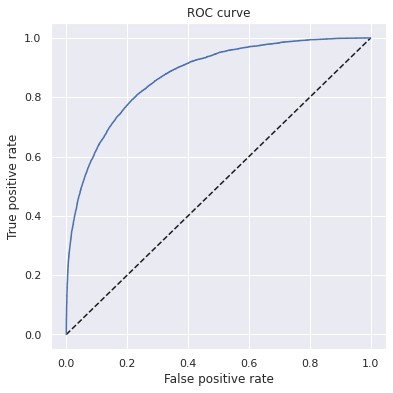

In [73]:
fpr_rf, tpr_rf, thresholds = roc_curve(y_true, y_test_pred_proba_best)

fig = plt.figure(4, figsize=(6, 6))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Meilleur modèle')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#### Score F1

In [74]:
f1_score(y_true, y_test_pred_proba_best > selected_threshold) # Attention, utiliser le seuil trouvé par validation croisée !

0.6233636703652912

#### Matrice de confusion

Confusion matrix, without normalization


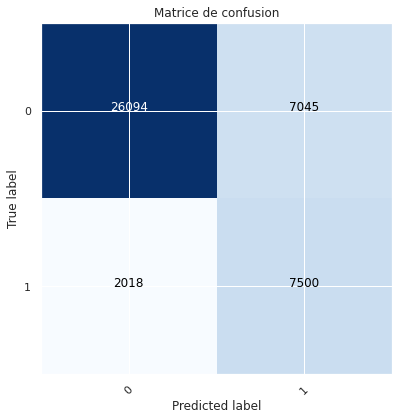

In [75]:
fig = plt.figure(3, figsize=(6, 6))

cnf_matrix = confusion_matrix(y_true, y_test_pred_proba_best > selected_threshold)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0','1'], title='Matrice de confusion')

In [81]:
# Accuracy
(26094+7500)/(26094+7500+7045+2018)

0.7875378015331599